<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Labwork-1.2.-Finding-answers-to-analytical-questions-with-SQL-for-data-stored-in-ClickHouse" data-toc-modified-id="Labwork-1.2.-Finding-answers-to-analytical-questions-with-SQL-for-data-stored-in-ClickHouse-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Labwork 1.2. Finding answers to analytical questions with SQL for data stored in ClickHouse</a></span></li><li><span><a href="#ClickHouse:-how-to-access-from-JupyterHub" data-toc-modified-id="ClickHouse:-how-to-access-from-JupyterHub-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>ClickHouse: how to access from JupyterHub</a></span><ul class="toc-item"><li><span><a href="#Import-libraries-and-set-access-parameters" data-toc-modified-id="Import-libraries-and-set-access-parameters-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Import libraries and set access parameters</a></span></li><li><span><a href="#How-to-access" data-toc-modified-id="How-to-access-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>How to access</a></span></li><li><span><a href="#Example-queries" data-toc-modified-id="Example-queries-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Example queries</a></span></li></ul></li><li><span><a href="#Self-control-stops" data-toc-modified-id="Self-control-stops-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Self-control stops</a></span></li></ul></div>

# Labwork 1.2. Finding answers to analytical questions with SQL for data stored in ClickHouse
In this lab we'll try ourselves in the typical analytical environment when answers to our questions are not yet in BI reports and dashboard, but are already presented in analytical database. One of the most popular databases for analytical purposes is ClickHouse, which is the main storage behind Yandex Metrika.

# ClickHouse: how to access from JupyterHub

[ClickHouse®](https://clickhouse.tech/) is a fast open-source OLAP database management system. It is column-oriented and allows to generate analytical reports using SQL queries in real-time.

We have a local installation of ClickHouse database that collects logs from [GSOM site](https://gsom.spbu.ru/) and is available in read-only format for you to learn how to use ClickHouse in your tasks.

## Import libraries and set access parameters

In [1]:
import os
import json
import requests
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

Set host and port to get to database. ClickHouse has no external IP address, so it is available only from JupyterHub notebooks:

In [2]:
# CH_HOST = 'http://10.129.0.30'
CH_HOST = 'http://51.250.107.52'
CH_PORT = '8123'
SSL_VERIFY = True

## How to access

Our main function for access to ClickHouse will take parameters like database host, username, password, query and will returd data from database:

In [3]:
def get_data(query, host, user_name, user_passwd):
    if (user_name == '') and (user_passwd == ''):
        r = requests.post(host, params=query_dict, verify=SSL_VERIFY)
    else:
        r = requests.post(host, data=query,
                          auth=(user_name, user_passwd), verify=SSL_VERIFY)
    print('request status code:', r.status_code)
    return r.text

In [4]:
CLICKHOUSE_USER = os.environ['CLICKHOUSE_USER']
CLICKHOUSE_PASSWORD = os.environ['CLICKHOUSE_PASSWORD']

In [5]:
def get_data_short(query):
    return get_data(query=query, 
                host=':'.join([CH_HOST, CH_PORT]),
                user_name=CLICKHOUSE_USER,
                user_passwd=CLICKHOUSE_PASSWORD)


ClickHouse uses [SQL syntax](https://clickhouse.tech/docs/en/sql-reference/syntax/) for its queries, so let's define our first query:

In [6]:
query = 'SHOW DATABASES'

...and put it to function:

In [7]:
data = get_data_short(query)

request status code: 200


__NOTE:__ Username (or login) and password are stored in environment variables `CLICKHOUSE_USER`, `CLICKHOUSE_PASSWORD` for safety and are available through `os` library as `os.environ['<ENV_VARIABLE_NAME>']`.

The data from database is returnes as string, so postprocessing is needed:

In [8]:
data = [x.split('\t') for x in data.split('\n')]
pd.DataFrame(data)

,0
0,gsomlogs
1,


In [9]:
print(data)

[['gsomlogs'], ['']]


In [10]:
os.environ['CLICKHOUSE_USER']

'logsreader'

## Example queries

Now we know what databases are in ClickHouse. Build a more complicated query to obtain names of all tables in database:

In [11]:
query = 'SHOW TABLES FROM gsomlogs'

In [12]:
data = get_data_short(query)
data = [x.split('\t') for x in data.split('\n')]
pd.DataFrame(data)

request status code: 200


,0
0,hits_all
1,visits_all
2,


Let's get fields of selected table:

In [13]:
query = 'SHOW CREATE TABLE gsomlogs.hits_all'

In [14]:
query = 'show create table gsomlogs.hits_all'
data = get_data_short(query=query)
print()
for x in data.split('\\n'):
    print(x)
    
# documentation for the fields can be found here: https://yandex.com/dev/metrika/doc/api2/logs/fields/hits.html

request status code: 200

CREATE TABLE gsomlogs.hits_all
(
    `Artificial` UInt8,
    `Browser` String,
    `BrowserCountry` String,
    `BrowserEngine` String,
    `BrowserEngineVersion1` UInt16,
    `BrowserEngineVersion2` UInt16,
    `BrowserEngineVersion3` UInt16,
    `BrowserEngineVersion4` UInt16,
    `BrowserLanguage` String,
    `BrowserMajorVersion` UInt16,
    `BrowserMinorVersion` UInt16,
    `ClientID` UInt64,
    `ClientTimeZone` Int16,
    `CookieEnabled` UInt8,
    `CounterID` UInt32,
    `Date` Date,
    `DateTime` DateTime,
    `DeviceCategory` String,
    `Download` UInt8,
    `From` String,
    `GCLID` String,
    `GoalsID` Array(UInt32),
    `HasGCLID` UInt8,
    `HttpError` String,
    `IFrame` UInt8,
    `IpAddress` String,
    `IsPageView` UInt8,
    `JavascriptEnabled` UInt8,
    `LastAdvEngine` String,
    `LastSearchEngine` String,
    `LastSearchEngineRoot` String,
    `LastSocialNetwork` String,
    `LastSocialNetworkProfile` String,
    `LastTrafficSource`

Now we are ready to deep dive into data in tables (but for the demo will limit our query for the first 5 rows):

In [15]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('display.expand_frame_repr', True)

In [16]:
query = 'SELECT * FROM gsomlogs.hits_all ORDER BY DateTime DESC LIMIT 100'
# documentation for the fields can be found here: https://yandex.com/dev/metrika/doc/api2/logs/fields/visits.html    

In [17]:
data = get_data_short(query=query)
data = [x.split('\t') for x in data.split('\n')]
df = pd.DataFrame(data)
df.head(100)

request status code: 200


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
0,0,chrome,ru,WebKit,537,36,0,0,ru,105,0,1653944031913714969,60,1,211680,2022-09-19,2022-09-19 23:53:44,1,0,,,[],0,0,0,2001:818:e20b:fd00::xxx,1,1,,,,,,internal,0,,,,0,,,,,windows10,windows,utf-8,864,1536,https://gsom.spbu.ru/research/blog/blog2018_07_27,Lisbon,10478,Portugal,10074,24,16:9,864,2,1536,,,,Высшая школа менеджмента СПбГУ,https://gsom.spbu.ru/search/search_do/?search_...,,,,,,5500836090302693574,816,765
1,0,chrome,ru,WebKit,537,36,0,0,ru,105,0,1653944031913714969,60,1,211680,2022-09-19,2022-09-19 23:53:20,1,0,,,[],0,0,0,2001:818:e20b:fd00::xxx,1,1,,,,,,internal,0,,,,0,,,,,windows10,windows,utf-8,864,1536,https://gsom.spbu.ru/search/search_do/?search_...,Lisbon,10478,Portugal,10074,24,16:9,864,2,1536,,,,Дарья Блохина поехала по обмену в Школу бизнес...,https://gsom.spbu.ru/students/blog/blog2018_07...,,,,,,5500829826884304940,816,765
2,0,chrome,ru,WebKit,537,36,0,0,ru,105,0,1661788534856449344,180,1,211680,2022-09-19,2022-09-19 23:51:07,1,0,,,[],0,0,0,93.100.193.xxx,1,1,,,,,,internal,0,,,,0,,,,,windows10,windows,utf-8,720,1280,https://gsom.spbu.ru/programmes/,Saint Petersburg,2,Russia,225,24,16:9,720,2,1280,,,,Направление «Государственное и муниципальное у...,https://gsom.spbu.ru/programmes/bachelor/publi...,,,,,,5500795011633774848,609,1263
3,0,firefox,ru,Gecko,104,0,0,0,ru,104,0,1603123410846598734,180,1,211680,2022-09-19,2022-09-19 23:50:12,1,0,,,[],0,0,0,94.19.206.xxx,1,1,,google_search,google,,,organic,0,,,,0,,,,,windows10,windows,utf-8,1080,1920,https://google.com/,Saint Petersburg,2,Russia,225,24,16:9,1080,2,1920,,,,Harvard Business Review – Россия,https://gsom.spbu.ru/gsom/library/index/hbr/,,,,,,5500780505061916716,955,1903
4,0,yandexsearch,,WebKit,605,1,15,0,ru,96,0,1663618949476479952,180,1,211680,2022-09-19,2022-09-19 23:49:51,2,0,,,[],0,0,0,109.252.53.xxx,1,1,,yandex_search,yandex,,,organic,0,apple,iPhone,,0,,,,,ios15,ios_double,utf-8,2778,1284,https://yandex.ru/,Moscow,213,Russia,225,32,9:21,926,1,428,,,,Бакалавриат: направление «Менеджмент» в ВШМ СП...,https://gsom.spbu.ru/programmes/bachelor/mened...,,,,,,5500775085952466965,736,428
5,0,safari_mobile,,WebKit,605,1,15,0,ru,15,6,166362047764977210,180,1,211680,2022-09-19,2022-09-19 23:48:54,2,0,,,[],0,0,0,2606:54c0:61e0:30::xxx,1,1,,google_search,google,,,organic,0,apple,iPhone,,0,,,,,ios15,ios_double,utf-8,1792,828,https://google.ru/,Nizhny Novgorod,47,Russia,225,32,9:21,896,1,414,,,,Кампус ВШМ СПбГУ,https://gsom.spbu.ru/students/campus/,,,,,,5500760204365005137,713,414
6,0,safari_mobile,,WebKit,605,1,15,0,ru,15,6,166362047764977210,180,1,211680,2022-09-19,2022-09-19 23:48:50,2,0,,,[],0,0,0,2606:54c0:61e0:30::xxx,1,1,,google_search,google,,,organic,0,apple,iPhone,,0,,,,,ios15,ios_double,utf-8,1792,828,https://google.ru/,Nizhny Novgorod,47,Russia,225,32,9:21,896,1,414,,,,Бакалавриат ВШМ СПбГУ - поступить в 2022 году,https://gsom.spbu.ru/programmes/bachelor/,,,,,,5500759090377261243,714,414
7,0,safari_mobile,,WebKit,605,1,15,0,ru,15,6,166362047764977210,180,1,211680,2022-09-19,2022-09-19 23:48:40,2,0,,,[],0,0,0,2606:54c0:61e0:30::xxx,1,1,,,,,,internal,0,apple,iPhone,,0,,,,,ios15,ios_double,utf-8,1792,828,https://gsom.spbu.ru/programmes/bachelor/,Nizhny Novgorod,47,Russia,225,32,9:21,896,1,414,,,,Бакалавриат: направление «Менеджмент» в ВШМ СП...,https://gsom.spbu.ru/programmes/bachelor/mened...,,,,,,5500756351136825420,715,414
8,0,safari_mobile,,WebKit,605,1,15,0,ru,15,6,166362047764977210,180,1,211680,2022-09-19,2022-09-19 23:48:11,2,0,,,[],0,0,0,2606:54c0:61e0:30::xxx,1,1,,google_search,google,,,organic,0,apple,iPhone,,0,,,,,ios15,ios_double,utf-8,1792,828,https://google.ru/,Nizhny Novgorod,47,Russia,225,32,9:21,896,1,414,,,,Бакалавриат ВШМ СПбГУ - поступить в 2022 году,https://gsom.spbu.ru/programmes/bachelor/,,,,,,5500748818537775340,713,414
9,0,safa

In [18]:
query = "SELECT Referer FROM gsomlogs.hits_all where Referer is not NULL"

In [19]:
data = get_data_short(query=query)
data = [x.split('\t') for x in data.split('\n')]
df = pd.DataFrame(data)
df.head(200)

request status code: 200


,0
0,https://google.com
1,https://gsom.spbu.ru/gsom/faculty/depts1/marke...
2,https://gsom.spbu.ru/programmes/bachelor/bache...
3,https://google.com/
4,http://google.com/
5,https://gsom.spbu.ru/
6,https://gsom.spbu.ru/gsom/kampus/
7,https://google.com/
8,https://google.com/
9,https://google.com/


# Self-control stops
1. Find out top 10 most popular pages on GSOM web sites for the last month. Draw a histogram showing number of unique
users for this pages.
<br>Hints: 
 - You can use date_sub function https://clickhouse.com/docs/en/sql-reference/functions/date-time-functions#date_sub and now function https://clickhouse.com/docs/en/sql-reference/functions/date-time-functions#now
 - To see the whole field in the dataframe you can change the column width display: `pd.set_option('display.max_colwidth', 1000)`
2. Find out top referers for MiBA landing page for the last month.
<br>Hints:
 - you can find all urls containing 'miba' and sort them by number of hits to see the most popular landing for miba
3. Find out top pages on the site for those visitors interested in MiBA program for the last month.
<br>Hints: 
 - you can use subquery with "IN" for that (https://clickhouse.com/docs/en/sql-reference/operators/in)
 - for long queries like this one it's better to use ''' syntax for strings instead of "
 - you can use DISTINCT for find distinct users: https://clickhouse.com/docs/en/sql-reference/statements/select/distinct 
4. Find out the number of all and direct visitors (those with empty referer) to MiBA program page for each day for the last week.


In [22]:
pd.set_option('display.max_colwidth', 1000)

In [23]:
#1 QUESTION 1
query= "SELECT URL, Count(Distinct ClientID) as am  from (select * from gsomlogs.hits_all where Date > DATE_SUB(NOW(), INTERVAL 30 DAY)) as A GROUP BY URL Order by am desc"

In [24]:
data = get_data_short(query=query)
data = [x.split('\t') for x in data.split('\n')]
df = pd.DataFrame(data)
df.head(10)

request status code: 200


,0,1
0,https://gsom.spbu.ru/,5104
1,https://gsom.spbu.ru/programmes/,1976
2,https://gsom.spbu.ru/programmes/bachelor/menedzhment/,1033
3,https://gsom.spbu.ru/programmes/bachelor/admissions/,834
4,https://gsom.spbu.ru/students/campus/gsom_campus/,724
5,https://gsom.spbu.ru/programmes/bachelor/,652
6,https://gsom.spbu.ru/events/event2022-09-01/,587
7,https://gsom.spbu.ru/en/,584
8,https://gsom.spbu.ru/about-gsom/contacts/,566
9,https://gsom.spbu.ru/about-gsom/,496


,0,1
9,https://gsom.spbu.ru/about-gsom/,496
8,https://gsom.spbu.ru/about-gsom/contacts/,566
7,https://gsom.spbu.ru/en/,584
6,https://gsom.spbu.ru/events/event2022-09-01/,587
5,https://gsom.spbu.ru/programmes/bachelor/,652
4,https://gsom.spbu.ru/students/campus/gsom_campus/,724
3,https://gsom.spbu.ru/programmes/bachelor/admissions/,834
2,https://gsom.spbu.ru/programmes/bachelor/menedzhment/,1033
1,https://gsom.spbu.ru/programmes/,1976
0,https://gsom.spbu.ru/,5104


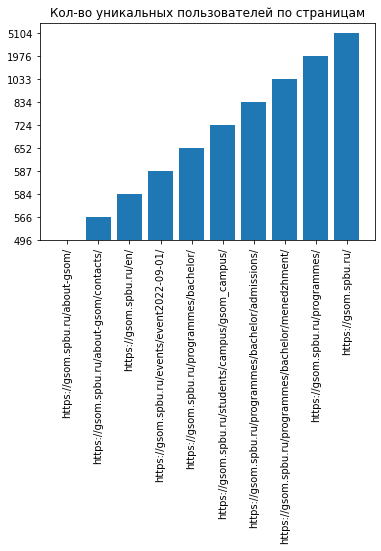

In [25]:
df1=df.iloc[:10, :]
df1=df1.sort_index(ascending=False)
plt.bar(df1[0],df1[1])
plt.xticks(rotation='vertical')
plt.title("Кол-во уникальных пользователей по страницам")
df1

In [26]:
#2 QUESTION 2
query= "SELECT Referer, COUNT(Referer) as am from (select * from gsomlogs.hits_all where Date> DATE_SUB(NOW(), INTERVAL 30 DAY) and URL like '%miba%' and  Referer is not null) as a group by Referer order by am desc   "

In [27]:
data = get_data_short(query=query)
data = [x.split('\t') for x in data.split('\n')]
df = pd.DataFrame(data)
df.head(10)

request status code: 200


,0,1
0,https://gsom.spbu.ru/programmes/,84
1,https://gsom.spbu.ru/programmes/graduate/,60
2,https://google.com/,51
3,,27
4,https://gsom.spbu.ru/en/programmes/graduate/,21
5,https://gsom.spbu.ru/,20
6,https://gsom.spbu.ru/en/programmes/,20
7,https://yandex.ru/,11
8,https://google.ru/,8
9,https://gsom.spbu.ru/gsom/career/doc/,6


In [28]:
df[0][0]

'https://gsom.spbu.ru/programmes/'

In [29]:
#3 Question 3
query='''Select URL ,count(distinct ClientID) as am from 
(select * from gsomlogs.hits_all where Date> DATE_SUB(MONTH, 1, toDate(NOW())) and URL like '%miba%') as a
GROUP by URL  Order by am desc
'''

In [30]:
data = get_data_short(query=query)
data = [x.split('\t') for x in data.split('\n')]
df = pd.DataFrame(data)
df.head(10)

request status code: 200


,0,1
0,https://gsom.spbu.ru/programmes/graduate/miba/,209
1,https://gsom.spbu.ru/en/programmes/graduate/miba/,53
2,https://gsom.spbu.ru/images/cms/data/2011_03_17_future_petersburg/miba_internship.docx,6
3,https://gsom.spbu.ru/programmes/graduate/candidates/miba-admissions/,2
4,,None


In [31]:
query='''select  URL, count(Distinct ClientID) from gsomlogs.hits_all where URL like '%miba%' and Date> DATE_SUB(MONTH, 1, toDate(now())) 
group by URL '''


In [32]:
data = get_data_short(query=query)
data = [x.split('\t') for x in data.split('\n')]
df = pd.DataFrame(data)
df.head(10)

request status code: 200


,0,1
0,https://gsom.spbu.ru/images/cms/data/2011_03_17_future_petersburg/miba_internship.docx,6
1,https://gsom.spbu.ru/en/programmes/graduate/miba/,53
2,https://gsom.spbu.ru/programmes/graduate/candidates/miba-admissions/,2
3,https://gsom.spbu.ru/programmes/graduate/miba/,209
4,,None


In [33]:
query='''select  Distinct ClientID, Title from gsomlogs.hits_all where URL like '%miba%' and Date> DATE_SUB(MONTH, 1, toDate(now()))



'''

In [34]:
data = get_data_short(query=query)
data = [x.split('\t') for x in data.split('\n')]
df = pd.DataFrame(data)
df.head(10)

request status code: 200


,0,1
0,1649222091913360835,«Бизнес-аналитика и большие данные» — программа ВШМ СПбГУ | Business Analytics and Big Data (MIBA)
1,1661144349885216057,«Бизнес-аналитика и большие данные» — программа ВШМ СПбГУ | Business Analytics and Big Data (MIBA)
2,1660557808670357505,Master in Business Analytics and Big Data (MiBA) - GSOM SPbU Master Program
3,1661175475525611686,«Бизнес-аналитика и большие данные» — программа ВШМ СПбГУ | Business Analytics and Big Data (MIBA)
4,1661175159817997659,«Бизнес-аналитика и большие данные» — программа ВШМ СПбГУ | Business Analytics and Big Data (MIBA)
5,1634281783587674201,Master in Business Analytics and Big Data (MiBA) - GSOM SPbU Master Program
6,1661170164156355112,«Бизнес-аналитика и большие данные» — программа ВШМ СПбГУ | Business Analytics and Big Data (MIBA)
7,1661194660487525361,«Бизнес-аналитика и большие данные» — программа ВШМ СПбГУ | Business Analytics and Big Data (MIBA)
8,1660578372882231069,«Бизнес-аналитика и большие данные» — программа ВШМ СПбГУ | Business Analytics and Big Data (MIBA)
9,1661157531335155355,«Бизнес-аналитика и большие данные» — программа ВШМ СПбГУ | Business Analytics and Big Data (MIBA)


In [35]:
df.shape

(271, 2)

In [36]:
#4 Question 4
query=''' select  CASE when Referer!='' then 1 else 0 as is_direct end, Date, count(distinct ClientID) from (
Select * from 
gsomlogs.hits_all where (Date between  date_sub(WEEK, 1, toDate(NOW())) and NOW()) 
and  (Title like '%Business Analytics and Big Data (MIBA)') ) as zuka
Group by CASE when Referer!='' then 1 else 0 as is_direct end, Date order by Date'''

In [37]:
data = get_data_short(query=query)
data = [x.split('\t') for x in data.split('\n')]
df = pd.DataFrame(data)
df.head(20)

request status code: 200


,0,1,2
0,1,2022-09-14,8
1,0,2022-09-15,1
2,1,2022-09-15,7
3,1,2022-09-16,12
4,1,2022-09-18,3
5,0,2022-09-19,1
6,1,2022-09-19,16
7,,None,None


In [38]:
df.shape

(8, 3)

In [39]:
df[0].value_counts()

1    5
0    2
     1
Name: 0, dtype: int64